In [7]:
import pandas as pd
import numpy as np
from io import BytesIO
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt

In [ ]:
# This is a temporaly line to run that adds the modules to the pythopath
import sys
sys.path.append('/home/azureuser/cloudfiles/code/Users/admin/Paychex_revenue_forecast')
from src.paychex_ml.utils import load_credentials

In [ ]:
credentials = load_credentials("blob_storage",
                               file="/home/azureuser/cloudfiles/code/Users/admin/Paychex_revenue_forecast/credentials.yml")

In [3]:
# Global Variables
conn_string = credentials['conn_string']
account_key = credentials['account_key']
container = 'clean-data'
parquet_file = 'paychex_revenue.parquet'
#https://paychexdeveastus.blob.core.windows.net/clean-data/paychex_revenue.parquet

cols = ['Scenario'
       ,'Version'
       ,'Fiscal_Year'
       ,'11 Payroll Blended Products'
       ,'12 W2 Revenue'
       ,'13 Delivery Revenue'
       ,'14 ASO Allocation'
       ,'15 Other Processing Revenue'
       ,'16 SurePayroll'
       ,'17 Total International'
       ,'20 Total 401k'
       ,'31 HR Solutions (excl PEO)'
       ,'40 Total Online Services'
       ,'50 Other Managment Solutions'
       ,'60 Total PEO'
       ,'70 Total Insurance Services'
       ,'80 Interest on Funds Held for Clients'
       ,'Fiscal_Period'
       ,'Calendar_Date']

nums = ['11 Payroll Blended Products'
       ,'12 W2 Revenue'
       ,'13 Delivery Revenue'
       ,'14 ASO Allocation'
       ,'15 Other Processing Revenue'
       ,'16 SurePayroll'
       ,'17 Total International'
       ,'20 Total 401k'
       ,'31 HR Solutions (excl PEO)'
       ,'40 Total Online Services'
       ,'50 Other Managment Solutions'
       ,'60 Total PEO'
       ,'70 Total Insurance Services'
       ,'80 Interest on Funds Held for Clients']

def pad_months(mnth):
    mnth = str(mnth)
    if int(mnth) < 10:
        mnth = '0'+mnth
    return mnth 

def convert_months(mnth):
    #mnth = str(mnth)
    c_mnth = 'ERROR'
    if mnth == '01':
        c_mnth = '06'
    elif mnth == '02':
        c_mnth = '07'
    elif mnth == '03':
        c_mnth = '08'
    elif mnth == '04':
        c_mnth = '09'
    elif mnth == '05':
        c_mnth = '10'
    elif mnth == '06':
        c_mnth = '11'
    elif mnth == '07':
        c_mnth = '12'
    elif mnth == '08':
        c_mnth = '01'
    elif mnth == '09':
        c_mnth = '02'
    elif mnth == '10':
        c_mnth = '03'
    elif mnth == '11':
        c_mnth = '04'
    elif mnth == '12':
        c_mnth = '05'
    return c_mnth
        
# convert to calendar date
def convert_dates(df):
    df['Fiscal_Month'] = df.apply(lambda x: pad_months(x['Fiscal_Month']), axis=1)
    df['Calendar_Month'] = df.apply(lambda x: convert_months(x['Fiscal_Month']), axis=1) 
    df['f_yr'] = df['Fiscal_Year'].astype(str).str.replace('FY','')
    df['f_yr'] = df['f_yr'].astype(int)
    df['c_yr'] = np.where(df['Fiscal_Month'].astype(int) <= 7, df['f_yr'] - 1, df['f_yr'])
    df['Fiscal_Period'] = df['Fiscal_Year'] + df['Fiscal_Month']
    df['Calendar_Date'] = '20' + df['c_yr'].astype(str) + df['Calendar_Month'] + '01'
    df.drop(columns=['Fiscal_Month','Calendar_Month','f_yr','c_yr'], inplace=True)
    return df

blob_service_client = BlobServiceClient.from_connection_string(conn_string)
container_client = blob_service_client.get_container_client(container=container)

downloaded_blob = container_client.download_blob(parquet_file)
bytes_io = BytesIO(downloaded_blob.readall())
df = pd.read_parquet(bytes_io)
df = df.reset_index() # This unpacks the three level index that we currently have in the parquet file

# Actual DF
act_df = df.loc[df['Scenario'] == 'Actual']
act_df = act_df.iloc[:,4:]
act_df.columns = act_df.columns.str.replace(r'\d+', '')

# External data
conn_string = "DefaultEndpointsProtocol=https;AccountName=paychexdeveastus;AccountKey=VUo8HcsvbRAHWaHwb2ALbjMhmdvrKTtCviF9CU+13FPtG/T97rs3RbVEIJwZVYFER8eMg879rptv+AStcQZB9Q==;EndpointSuffix=core.windows.net"
account_key = "VUo8HcsvbRAHWaHwb2ALbjMhmdvrKTtCviF9CU+13FPtG/T97rs3RbVEIJwZVYFER8eMg879rptv+AStcQZB9Q=="
container = 'external-data'
parquet_file = 'external_data_fred.parquet'
#https://paychexdeveastus.blob.core.windows.net/clean-data/paychex_revenue.parquet

blob_service_client = BlobServiceClient.from_connection_string(conn_string)
container_client = blob_service_client.get_container_client(container=container)

downloaded_blob = container_client.download_blob(parquet_file)
bytes_io = BytesIO(downloaded_blob.readall())
edf = pd.read_parquet(bytes_io)
edf = edf.reset_index() # This unpacks the three level index that we currently have in the parquet file
edf=edf.sort_values(by=['date'])
edf=edf.rename(columns = {'date': 'Calendar Date'}, inplace = False)

#Join everything
full = pd.merge(act_df,edf,on='Calendar Date',how='left')

In [15]:
# Set corretlation matrix
correlation_df = full.corr()
correlation_df = correlation_df.iloc[ : , :14]
correlation_df.style.background_gradient(cmap='coolwarm')

,Payroll Blended Products,W Revenue,Delivery Revenue,ASO Allocation,Other Processing Revenue,SurePayroll,Total International,Total k,HR Solutions (excl PEO),ASO Revenue - Oasis,HR Online,Time Attendance,Total Paychex Advance,Full Service Unemployment Revenue
Payroll Blended Products,1.000000,-0.070977,0.261530,0.268759,0.265287,0.156631,-0.067796,-0.047959,0.258155,-0.112811,0.673706,0.063480,0.096317,0.454415
W Revenue,-0.070977,1.000000,0.740716,-0.002627,0.583646,0.003722,0.003953,0.016144,-0.000467,0.060893,0.146434,0.054459,0.055217,0.024619
Delivery Revenue,0.261530,0.740716,1.000000,0.086311,0.782214,-0.037621,-0.021961,-0.001641,0.083472,-0.001182,0.313486,0.046050,0.097921,0.142876
ASO Allocation,0.268759,-0.002627,0.086311,1.000000,0.227175,0.789468,0.890315,0.872272,0.998615,0.653268,-0.128992,0.925736,0.752760,0.921609
Other Processing Revenue,0.265287,0.583646,0.782214,0.227175,1.000000,0.131664,0.101513,0.113533,0.227370,0.138055,0.376773,0.182366,0.265967,0.292316
SurePayroll,0.156631,0.003722,-0.037621,0.789468,0.131664,1.000000,0.719708,0.739069,0.794782,0.488444,-0.166662,0.786586,0.653489,0.727418
Total International,-0.067796,0.003953,-0.021961,0.890315,0.101513,0.719708,1.000000,0.903244,0.889649,0.761289,-0.452526,0.879234,0.650875,0.724659
Total k,-0.047959,0.016144,-0.001641,0.872272,0.113533,0.739069,0.903244,1.000000,0.876068,0.666649,-0.369529,0.878046,0.693408,0.730855
HR Solutions (excl PEO),0.258155,-0.000467,0.083472,0.998615,0.227370,0.794782,0.889649,0.876068,1.000000,0.650819,-0.118308,0.938544,0.779127,0.926225
ASO Revenue - Oasis,-0.112811,0.060893,-0.001182,0.653268,0.138055,0.488444,0.761289,0.666649,0.650819,1.000000,-0.410306,0.659220,0.437309,0.516731


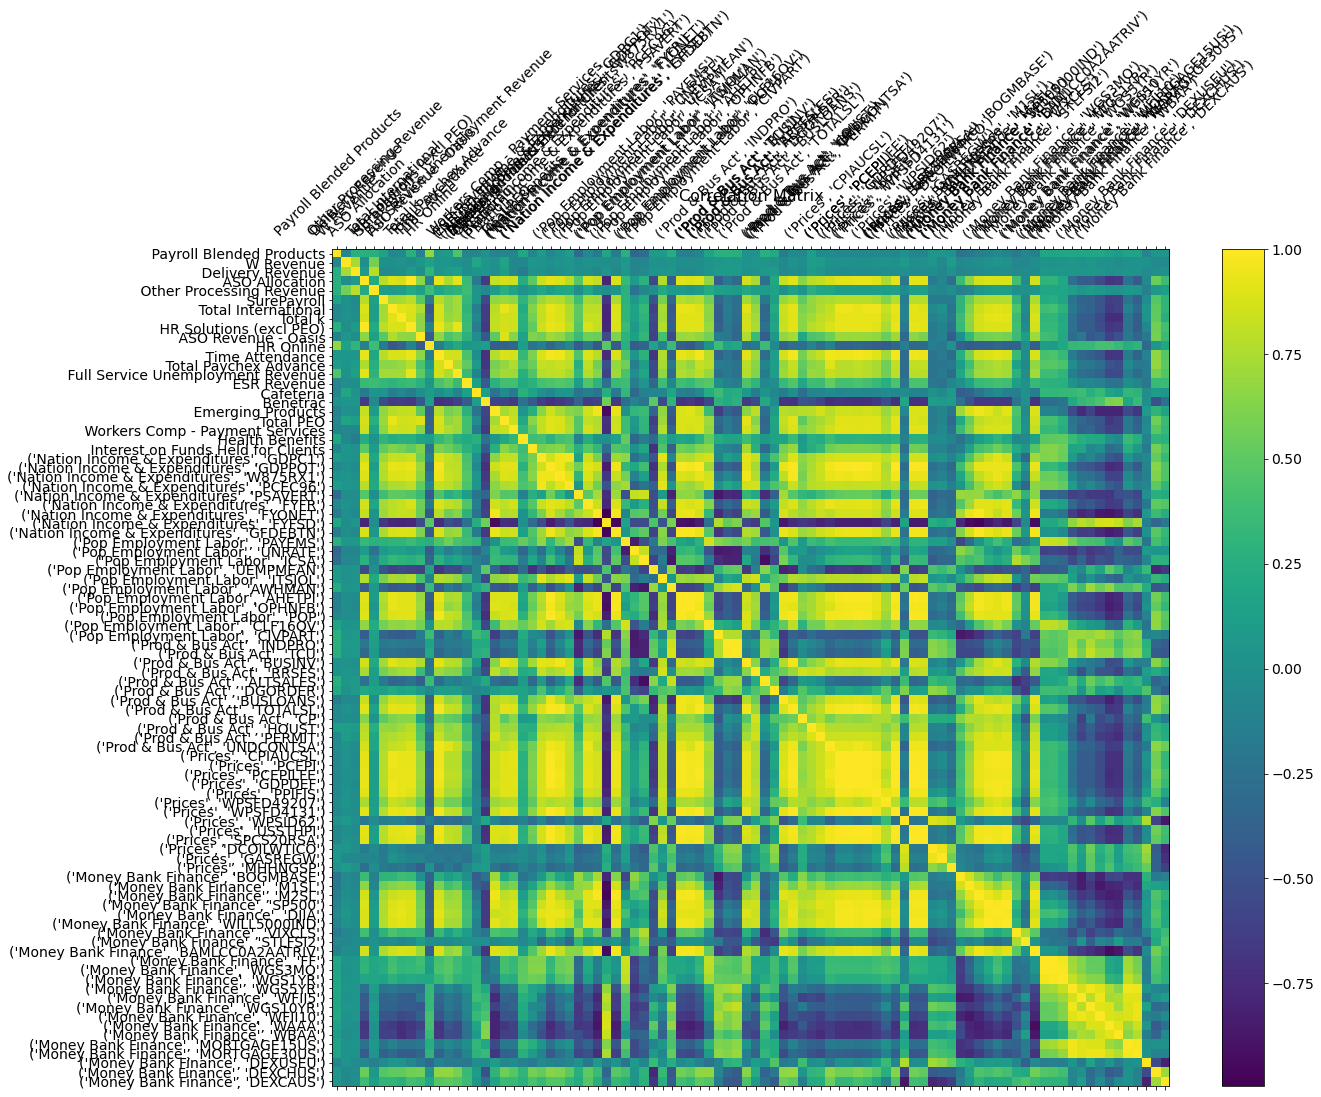

In [16]:
#COrr plot

f = plt.figure(figsize=(19, 15))
plt.matshow(full.corr(), fignum=f.number)
plt.xticks(range(full.select_dtypes(['number']).shape[1]), full.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(full.select_dtypes(['number']).shape[1]), full.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
